In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
train = pd.read_csv('../../input/Allstate/train.csv.zip')
test = pd.read_csv('../../input/Allstate/test.csv.zip')
submission = pd.read_csv('../../input/Allstate/sample_submission.csv.zip')

In [3]:
train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [4]:
cats = [col for col in train.columns if col.startswith('cat')]
conts = [col for col in train.columns if col.startswith('cont')]

len(cats), len(conts)

(116, 14)

<AxesSubplot:>

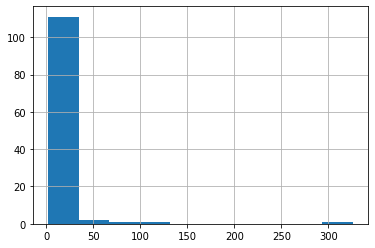

In [5]:
train[cats].nunique().hist()

In [6]:
len(train), len(test)

(188318, 125546)

In [9]:
def plot_loss(loss):
    loss.sort()

    fig, (ax1, ax2, ax3) = a = plt.subplots(ncols=3, figsize=(15,4))
    plt.tight_layout(pad=3)

    ax1.hist(loss)
    ax2.plot(loss)
    sns.histplot(loss, label='loss', kde=True, linewidth=0, stat='density')
    
    print(loss.min(), loss.max())

In [11]:
((train['loss'].values) < 400).mean()

0.010938943701611104

0.67 121012.25


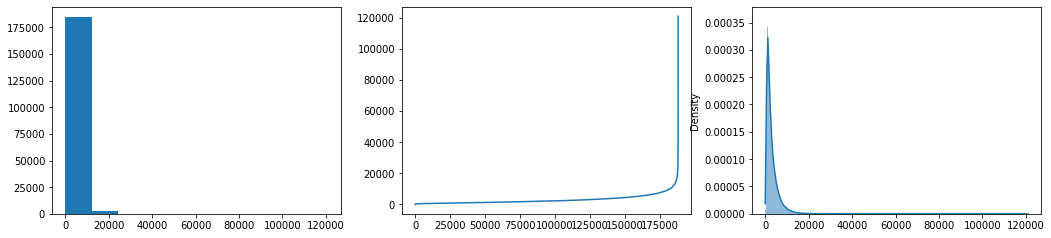

In [12]:
plot_loss(train['loss'].values)

-0.40047756659712525 11.703647059123911


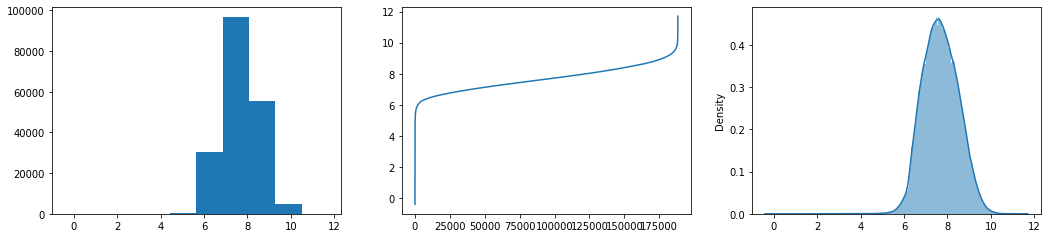

In [13]:
plot_loss(np.log(train['loss'].values))

5.301661767798426 11.70529842011712


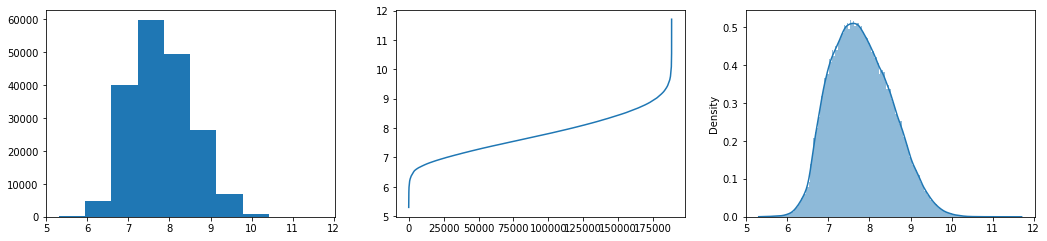

In [14]:
plot_loss(np.log(train['loss'].values+200))

9.210407369731783 11.783046109261749


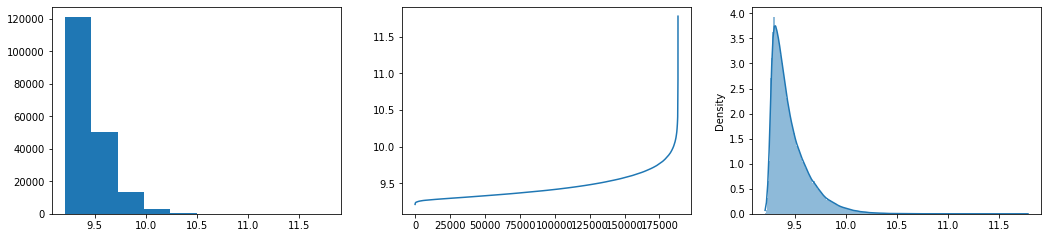

In [15]:
plot_loss(np.log(train['loss'].values+10000))

In [17]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin

In [31]:
c_selector = ColumnSelector(cats)

In [32]:
c_selector.fit_transform(train)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,A,B,A,B,A,A,A,A,B,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,A,B,A,A,A,A,A,A,B,B,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,A,B,A,A,B,A,A,A,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,B,A,B,A,A,A,A,B,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,A,B,A,B,A,A,A,A,B,B,...,G,B,H,C,C,Y,BM,A,K,CK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,A,B,A,A,A,A,A,A,B,A,...,G,B,BI,EG,A,G,BM,A,L,CK
188314,A,A,A,A,A,B,A,A,A,A,...,F,B,BI,BT,A,AV,AU,E,J,DF
188315,A,B,A,A,A,A,A,B,B,A,...,F,B,BI,DM,A,W,AF,A,K,DJ
188316,A,B,A,A,A,A,A,A,B,B,...,J,K,BI,AI,A,AS,AJ,A,O,MD


In [29]:
class ColumnSelector(TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self, X):
        return self
    def transform(self, X):
        return X[self.cols]

In [51]:
train_X = train.drop(columns='loss')
train_y = np.log(train['loss']+200)
test_X = test

In [49]:
process_cats = Pipeline([('select cats', ColumnSelector(cats)), ('to_dummies', FunctionTransformer(pd.get_dummies))])
process_conts = Pipeline([('select conts', ColumnSelector(conts)), ('scale', StandardScaler())])

In [102]:
union = FeatureUnion([('cats', process_cats), ('conts', process_conts)])

In [105]:
union.fit_transform(train_X)

(188318, 1153)

In [114]:
X_train, X_valid, y_train, y_valid = train_test_split(union.fit_transform(train_X), train_y, test_size=0.2)

In [115]:
rf = RandomForestRegressor(criterion='mae', n_jobs=-1)

In [116]:
%%time

rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
rf.score(X_)

In [ ]:
rf.fit(union.fit_transform(train_X))

In [ ]:
pipe = Pipeline()

In [107]:
from sklearn.ensemble import RandomForestRegressor

In [100]:
((train_X[conts[0]] - train_X[conts[0]].mean()) / train_X[conts[0]].std()).std()

1.0

In [90]:
a = StandardScaler().fit_transform(train_X[conts])

In [98]:
a[:, 0].std()

0.9999999999999998

In [85]:
o[0].var()

1.254932149536096

In [73]:
o[0].var()

1.254932149536096

In [56]:
process_cats.named_steps['select cats']

In [ ]:
process_conts = 

In [44]:
fu

FeatureUnion(transformer_list=[('select cats',
                                <__main__.ColumnSelector object at 0x7f2dbe8b0730>),
                               ('select conts',
                                <__main__.ColumnSelector object at 0x7f2dbe8b07f0>)])

In [34]:
fu = FeatureUnion([, ('select conts', ColumnSelector(conts))])

In [36]:
train.shape

(188318, 132)

In [40]:
train.columns

Index(['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9',
       ...
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'cont14', 'loss'],
      dtype='object', length=132)

In [37]:
fu.fit_transform(train).shape

(188318, 130)

In [ ]:
Pipeline([('sel_cols', )])

In [108]:
dummy = pd.get_dummies(train[cats[:5]])
dummy

,cat1_A,cat1_B,cat2_A,cat2_B,cat3_A,cat3_B,cat4_A,cat4_B,cat5_A,cat5_B
0,1,0,0,1,1,0,0,1,1,0
1,1,0,0,1,1,0,1,0,1,0
2,1,0,0,1,1,0,1,0,0,1
3,0,1,0,1,1,0,0,1,1,0
4,1,0,0,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
188313,1,0,0,1,1,0,1,0,1,0
188314,1,0,1,0,1,0,1,0,1,0
188315,1,0,0,1,1,0,1,0,1,0
188316,1,0,0,1,1,0,1,0,1,0


In [10]:
np.random.seed(123)
index = list(train.index)
print(index[0:10])
np.random.shuffle(index)
print(index[0:10])
train = train.iloc[index]
'train = train.iloc[np.random.permutation(len(train))]'

## set test loss to NaN
test['loss'] = np.nan

## response and IDs
## We are log-transforming the target

y = np.log(train['loss'].values+200)
id_train = train['id'].values
id_test = test['id'].values

## stack train test
ntrain = train.shape[0]
tr_te = pd.concat((train, test), axis = 0)

## Preprocessing and transforming to sparse data
sparse_data = []

f_cat = [f for f in tr_te.columns if 'cat' in f]
for f in f_cat:
    dummy = pd.get_dummies(tr_te[f].astype('category'))
    tmp = csr_matrix(dummy)
    sparse_data.append(tmp)

f_num = [f for f in tr_te.columns if 'cont' in f]
scaler = StandardScaler()
tmp = csr_matrix(scaler.fit_transform(tr_te[f_num]))
sparse_data.append(tmp)

del(tr_te, train, test)

## sparse train and test data
xtr_te = hstack(sparse_data, format = 'csr')
xtrain = xtr_te[:ntrain, :]
xtest = xtr_te[ntrain:, :]

print('Dim train', xtrain.shape)
print('Dim test', xtest.shape)

del(xtr_te, sparse_data, tmp)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[33898, 43407, 3458, 100139, 60086, 117290, 89806, 7751, 164059, 143297]
Dim train (188318, 1190)
Dim test (125546, 1190)


In [11]:
y

array([7.56987608, 7.84829365, 7.41602364, ..., 7.33236921, 9.17228019,
       6.37051723])

In [13]:
# Separate features and targets
X = xtrain.toarray()
Y = y

# Set the input shape
input_shape = (xtrain.shape[1],)
print(f'Feature shape: {input_shape}')

# Create the model
model = Sequential()
model.add(Dense(16, input_shape=input_shape, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
del xtrain
gc.collect()
gc.collect()

Feature shape: (1190,)


2022-06-06 07:24:02.546268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 07:24:02.555097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 07:24:02.555554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 07:24:02.556647: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

0

In [14]:
X

array([[ 0.        ,  1.        ,  1.        , ..., -0.95914517,
        -0.61232072, -1.26329393],
       [ 1.        ,  0.        ,  1.        , ...,  0.39395194,
        -0.71240011, -1.1963163 ],
       [ 1.        ,  0.        ,  1.        , ...,  0.91652738,
         0.94750019, -0.90385702],
       ...,
       [ 0.        ,  1.        ,  1.        , ..., -0.83567771,
        -0.01839175,  1.55127219],
       [ 1.        ,  0.        ,  0.        , ..., -0.23903515,
        -0.80958157, -0.56602101],
       [ 0.        ,  1.        ,  1.        , ...,  0.39395194,
         1.53407398, -0.95125139]])

In [18]:
## neural net
def nn_model():
    model = Sequential()
    
    model.add(Dense(400, input_dim = X.shape[1], kernel_initializer = 'he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
        
    model.add(Dense(200, kernel_initializer = 'he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())    
    model.add(Dropout(0.2))
    
    model.add(Dense(50, kernel_initializer = 'he_normal'))
    model.add(PReLU())
    model.add(BatchNormalization())    
    model.add(Dropout(0.2))
    
    model.add(Dense(1, kernel_initializer = 'he_normal'))
    model.compile(loss = 'mae', optimizer = 'adadelta')
    return(model)

In [22]:
Y

array([7.56987608, 7.84829365, 7.41602364, ..., 7.33236921, 9.17228019,
       6.37051723])

In [26]:
%%time

test_preds_total = 0
N_SPLITS = 5

kf = KFold(n_splits=N_SPLITS, random_state=137, shuffle=True)
for train_index, val_index in kf.split(X):
    print("TRAIN:", train_index, "VAL:", val_index)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = nn_model()
    model.fit(X_train, y_train, epochs=600, batch_size=1024, verbose=0)
    
    val_preds = np.exp(model.predict(X_val))-200
    error = mean_absolute_error(np.exp(y_val)-200, val_preds)
    
    print(f'Fold mae: {error}')
    
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=0)
    
    val_preds = np.exp(model.predict(X_val))-200
    error = mean_absolute_error(np.exp(y_val)-200, val_preds)
    
    print(f'Fold mae: {error}')
    
    model.compile(loss='mae', optimizer='adam', metrics=['mae'])
    model.fit(X_train, y_train, epochs=20, batch_size=50, verbose=0)
    
    val_preds = np.exp(model.predict(X_val))-200
    error = mean_absolute_error(np.exp(y_val)-200, val_preds)
    
    print(f'Fold mae: {error}')
    
    test_preds = np.exp(model.predict(xtest))-200
    test_preds_total += test_preds/N_SPLITS


TRAIN: [     1      2      4 ... 188313 188314 188315] VAL: [     0      3      6 ... 188309 188316 188317]
Fold mae: 1426.1004693510822
Fold mae: 1151.7130172695136
Fold mae: 1147.834260356096
TRAIN: [     0      2      3 ... 188315 188316 188317] VAL: [     1      5      8 ... 188300 188305 188306]
Fold mae: 1482.6282695513896
Fold mae: 1149.7667657346246
Fold mae: 1154.610037790005
TRAIN: [     0      1      2 ... 188314 188316 188317] VAL: [    16     17     30 ... 188310 188311 188315]
Fold mae: 1436.7284508900086
Fold mae: 1160.4965557379712
Fold mae: 1154.5343910471383
TRAIN: [     0      1      3 ... 188315 188316 188317] VAL: [     2      7     10 ... 188299 188307 188313]
Fold mae: 1454.026424503341
Fold mae: 1132.8270284451994
Fold mae: 1138.7273166313523
TRAIN: [     0      1      2 ... 188315 188316 188317] VAL: [     4     13     25 ... 188308 188312 188314]
Fold mae: 1581.4770286744435
Fold mae: 1156.7994244260467
Fold mae: 1139.7938525847621
CPU times: user 1h 55min 14s

In [27]:
test_preds_total

array([[1570.043  ],
       [1765.6118 ],
       [9318.161  ],
       ...,
       [2371.4565 ],
       [ 969.34357],
       [3233.838  ]], dtype=float32)

In [28]:
val_preds

array([[9739.92  ],
       [1294.9211],
       [3418.0183],
       ...,
       [3772.5396],
       [2409.1924],
       [4687.072 ]], dtype=float32)

In [29]:
submission['loss'] = test_preds_total
submission.to_csv('../submissions/sub_simple_mlp_5_fold_0.csv', index=False)
submission.head()

,id,loss
0,4,1570.042969
1,6,1765.611816
2,9,9318.161133
3,12,7524.106934
4,15,826.004578


This submission scores 1115.43903 on the public leaderboard, and 1127.08074 on the private one.
